# Load data

In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
with open('../source/output/results.json') as data_file:    
    data = json.load(data_file)

In [3]:
categories = np.array([x for x in  range(2500, 72500, 5000)])
reaches = np.array([x for x in range(0, 1500, 500)])

In [4]:
results = list()
for node in data['nodes']:
    for result in node['tag_results']:
        result['configuration']['id'] = node['id']
        results.append(result)

# Approximation algorithm

## Best scores

In [5]:
for result in results:
    if len(result['output']['paths']):
        result['output']['bestOutput'] = min(result['output']['paths'], key=lambda p: p['tags']['score'])

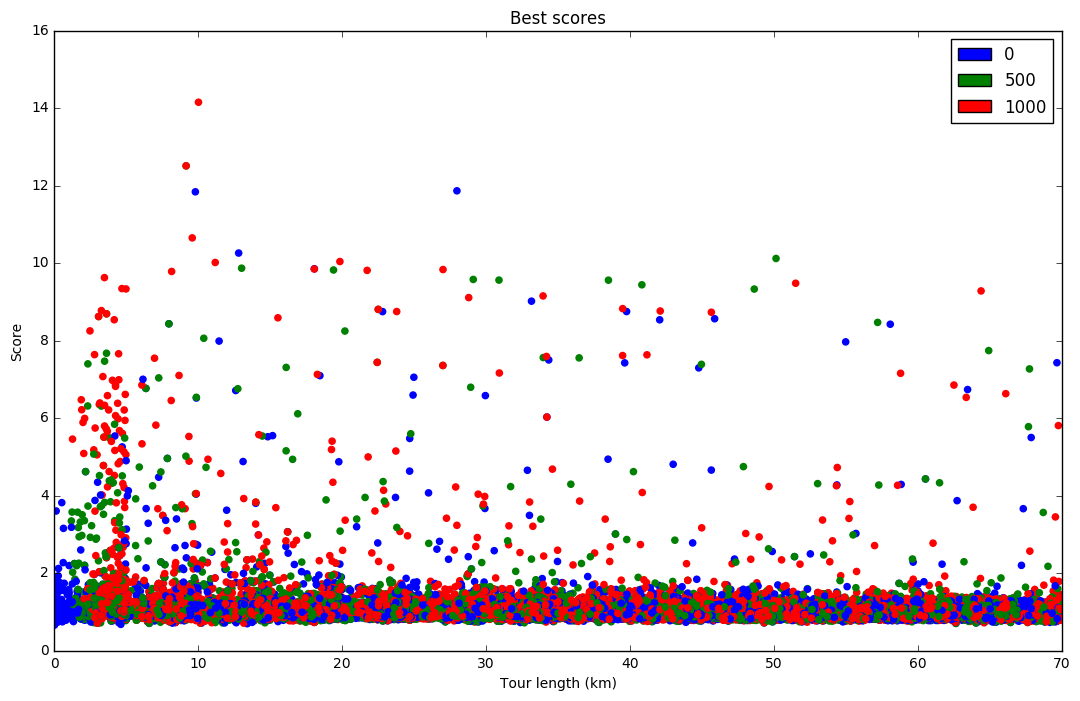

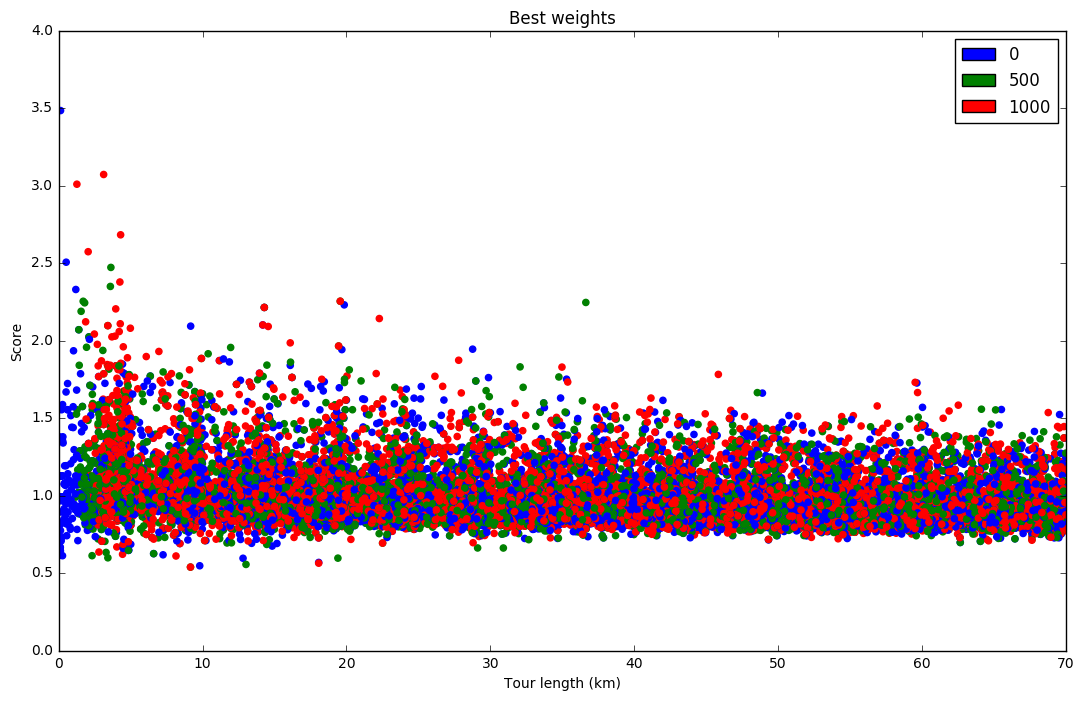

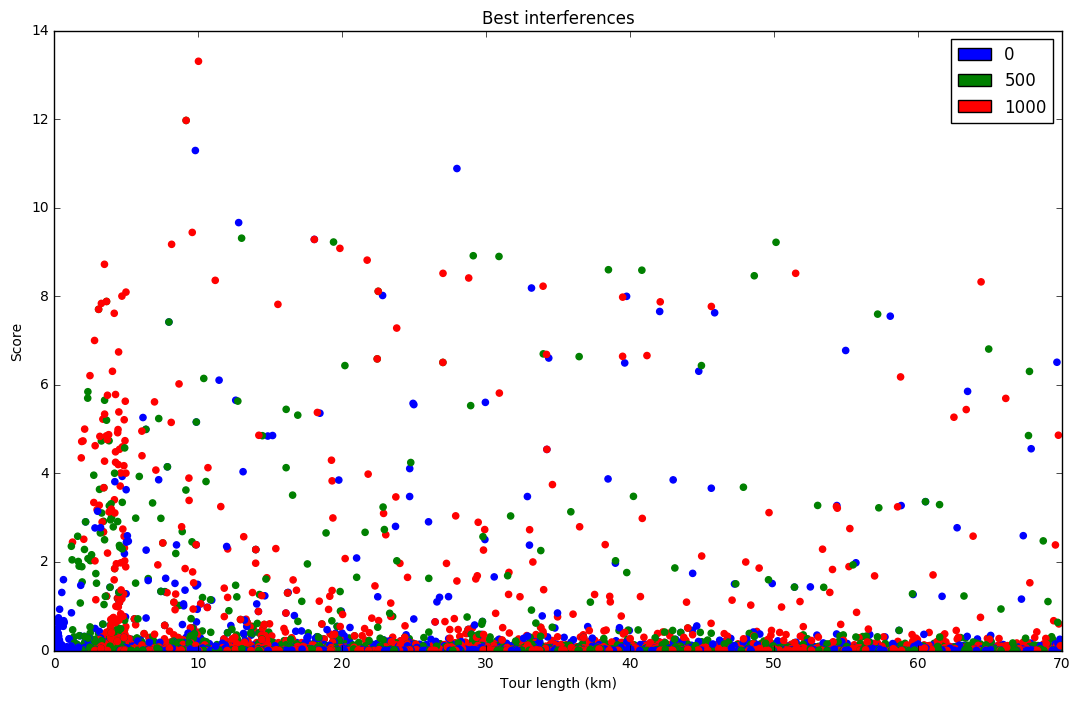

In [6]:
colors = ['b', 'g', 'r']
lens = [float(result['output']['bestOutput']['tags']['length'])/1000 for result in results if 'bestOutput' in result['output']]
score = [float(result['output']['bestOutput']['tags']['score']) for result in results if 'bestOutput' in result['output']]
weights = [float(result['output']['bestOutput']['tags']['weight']) for result in results if 'bestOutput' in result['output']]
interfs = [float(result['output']['bestOutput']['tags']['interf']) for result in results if 'bestOutput' in result['output']]
types = [colors[int(result['configuration']['reach']/500)] for result in results if 'bestOutput' in result['output']]
plt.figure(figsize=(13, 8))
plt.title('Best scores')
plt.scatter(lens, score, color=types)
plt.xlim([0, 70])
plt.ylim(ymin=0)
plt.ylabel('Score')
plt.xlabel('Tour length (km)')
plt.legend((plt.Circle((0, 0), 1, fc='b'), plt.Circle((0, 0), 1, fc='g'), plt.Circle((0, 0), 1, fc='r')), ('0', '500', '1000'))
plt.show()
plt.figure(figsize=(13, 8))
plt.title('Best weights')
plt.scatter(lens, weights, color=types)
plt.xlim([0, 70])
plt.ylim(ymin=0)
plt.ylabel('Score')
plt.xlabel('Tour length (km)')
plt.legend((plt.Circle((0, 0), 1, fc='b'), plt.Circle((0, 0), 1, fc='g'), plt.Circle((0, 0), 1, fc='r')), ('0', '500', '1000'))
plt.show()
plt.figure(figsize=(13, 8))
plt.title('Best interferences')
plt.scatter(lens, interfs, color=types)
plt.xlim([0, 70])
plt.ylim(ymin=0)
plt.ylabel('Score')
plt.xlabel('Tour length (km)')
plt.legend((plt.Circle((0, 0), 1, fc='b'), plt.Circle((0, 0), 1, fc='g'), plt.Circle((0, 0), 1, fc='r')), ('0', '500', '1000'))
plt.show()

In [7]:
outliers = list()
confs = 0
interf_confs = 0
unachieved_confs = 0
for node in data['nodes']:
    ls = list()
    for result in node['tag_results']:
        if result['configuration']['reach']==0:
            confs += 1
            if 'bestOutput' in result['output']:
                if float(result['output']['bestOutput']['tags']['interf'])>1:
                    ls.append(str(result['configuration']['minLength'])+'-'+str(result['configuration']['maxLength']))
                    interf_confs += 1
            else:
                unachieved_confs += 1
                ls.append(-1)
    if len(ls):
        outliers.append({'id': node['id'], 'lat': node['lat'], 'lon': node['lon'], 'problems': str(ls).replace('\'', '')})
        
with open('best_outliers.json', 'w') as data_file:
    json.dump({'nodes': outliers}, data_file)
    
print("Outlier nodes: " + str(100*float(len(outliers))/len(data['nodes'])) + '%')
print("High intereference configurations: " + str(100*float(interf_confs)/confs) + '%')
print("Unachieved configurations: " + str(100*float(unachieved_confs)/confs) + '%')

Outlier nodes: 9.0%
High intereference configurations: 1.5142857142857142%
Unachieved configurations: 0.0%


In [8]:
bests_per_category = [[list() for category in categories] for reach in reaches]
for result in results:
    if 'bestOutput' in result['output']:
        bests_per_category[int(result['configuration']['reach']/500)][int(result['configuration']['minLength']/5000)].append(float(result['output']['bestOutput']['tags']['score']))

for i in range(len(bests_per_category)):
    for j in range(len(bests_per_category[i])):
        bests_per_category[i][j] = np.array(bests_per_category[i][j])

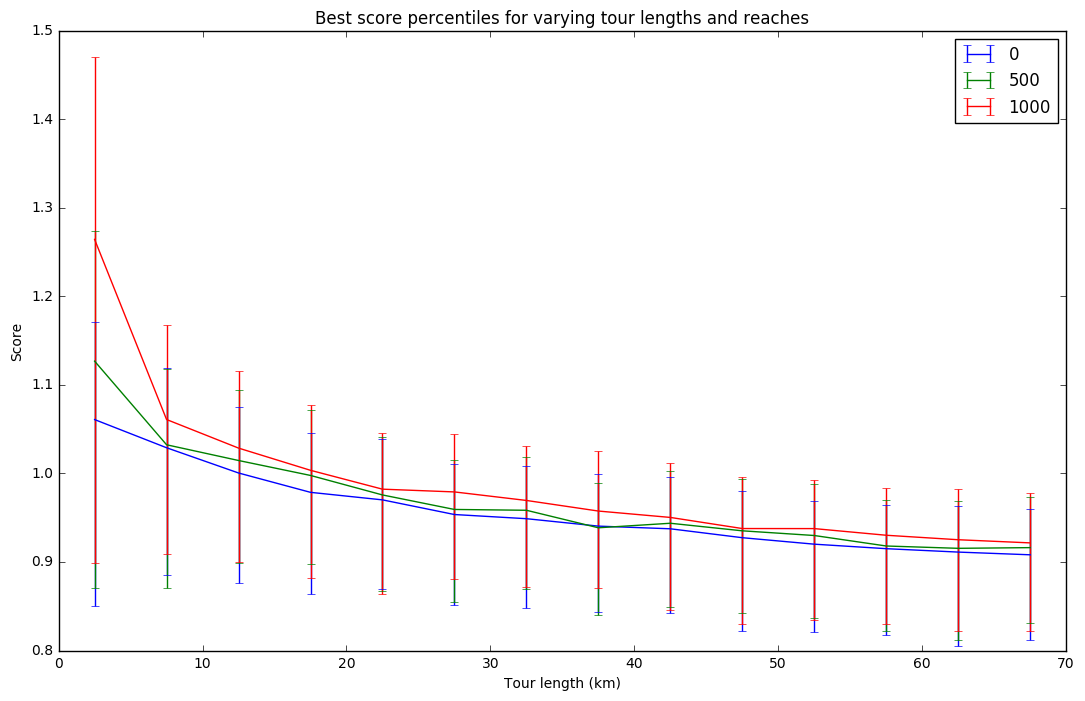

In [9]:
p50_per_category = [np.array([np.percentile(bests_per_category[i][j], 50) for j in range(len(bests_per_category[i]))]) for i in range(len(bests_per_category))]
p75_per_category = [np.array([np.percentile(bests_per_category[i][j], 75) for j in range(len(bests_per_category[i]))]) for i in range(len(bests_per_category))]
p25_per_category = [np.array([np.percentile(bests_per_category[i][j], 25) for j in range(len(bests_per_category[i]))]) for i in range(len(bests_per_category))]

plt.figure(figsize=(13, 8))
plt.errorbar(categories/1000, p50_per_category[0], yerr=[p75_per_category[0]-p50_per_category[0], p50_per_category[0]-p25_per_category[0]], label='0')
plt.errorbar(categories/1000, p50_per_category[1], yerr=[p75_per_category[1]-p50_per_category[1], p50_per_category[1]-p25_per_category[1]], label='500')
plt.errorbar(categories/1000, p50_per_category[2], yerr=[p75_per_category[2]-p50_per_category[2], p50_per_category[2]-p25_per_category[2]], label='1000')
plt.title('Best score percentiles for varying tour lengths and reaches')
plt.ylabel('Score')
plt.xlabel('Tour length (km)')
plt.legend()

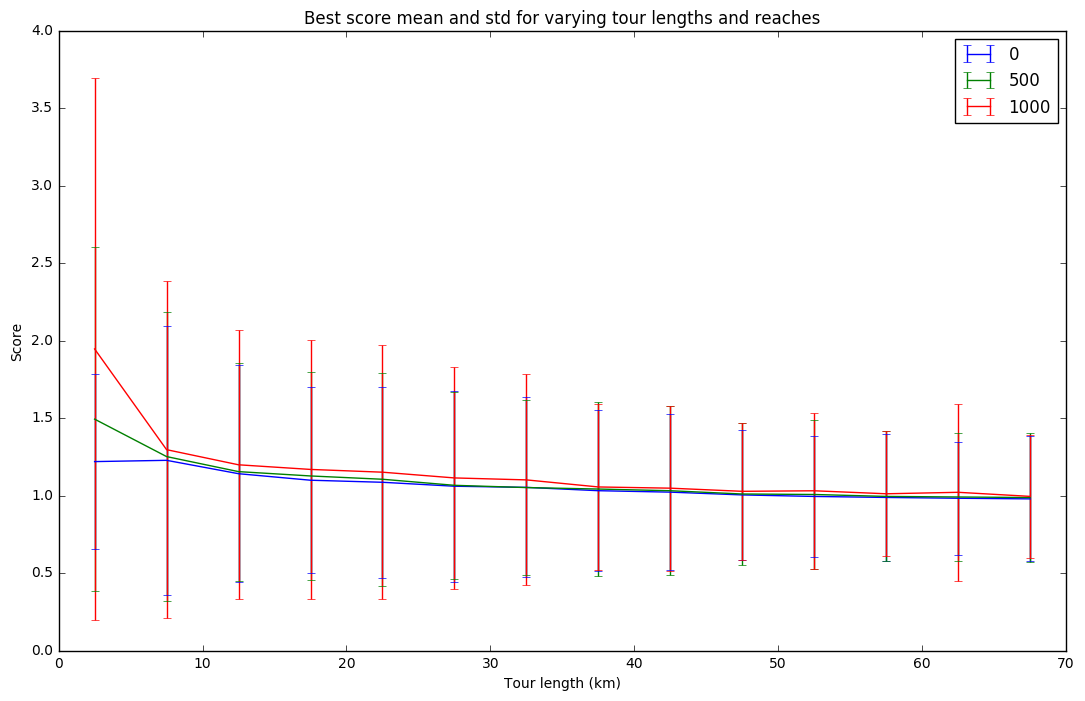

In [10]:
avg_per_category = [[np.mean(bests_per_category[i][j]) for j in range(len(bests_per_category[i]))] for i in range(len(bests_per_category))]
std_per_category = [[np.std(bests_per_category[i][j]) for j in range(len(bests_per_category[i]))] for i in range(len(bests_per_category))]

plt.figure(figsize=(13, 8))
plt.errorbar(categories/1000, avg_per_category[0], yerr=std_per_category[0], label='0')
plt.errorbar(categories/1000, avg_per_category[1], yerr=std_per_category[1], label='500')
plt.errorbar(categories/1000, avg_per_category[2], yerr=std_per_category[2], label='1000')
plt.title('Best score mean and std for varying tour lengths and reaches')
plt.ylabel('Score')
plt.xlabel('Tour length (km)')
plt.legend()

## All scores

In [11]:
paths = list()
for node in data['nodes']:
    for result in node['tag_results']:
        for path in result['output']['paths']:
            path['id'] = node['id']
            path['minLength'] = result['configuration']['minLength']
            path['maxLength'] = result['configuration']['maxLength']
            path['id'] = node['id']
            path['bestScore'] = result['output']['bestScore']
            path['reach'] = result['configuration']['reach']
            paths.append(path)

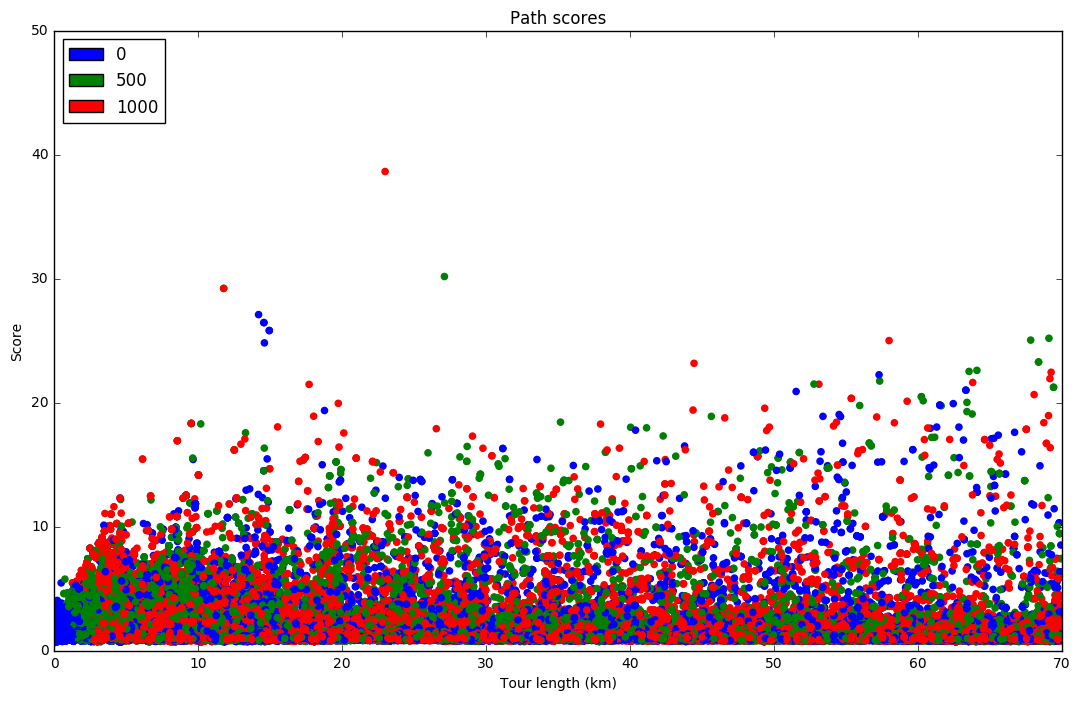

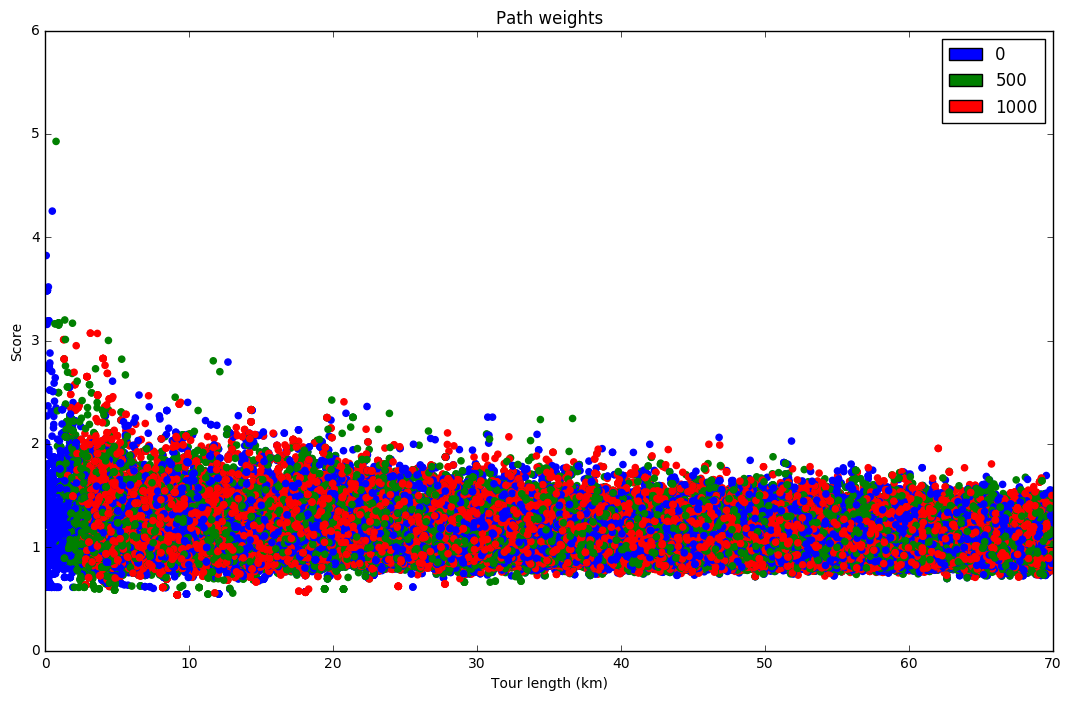

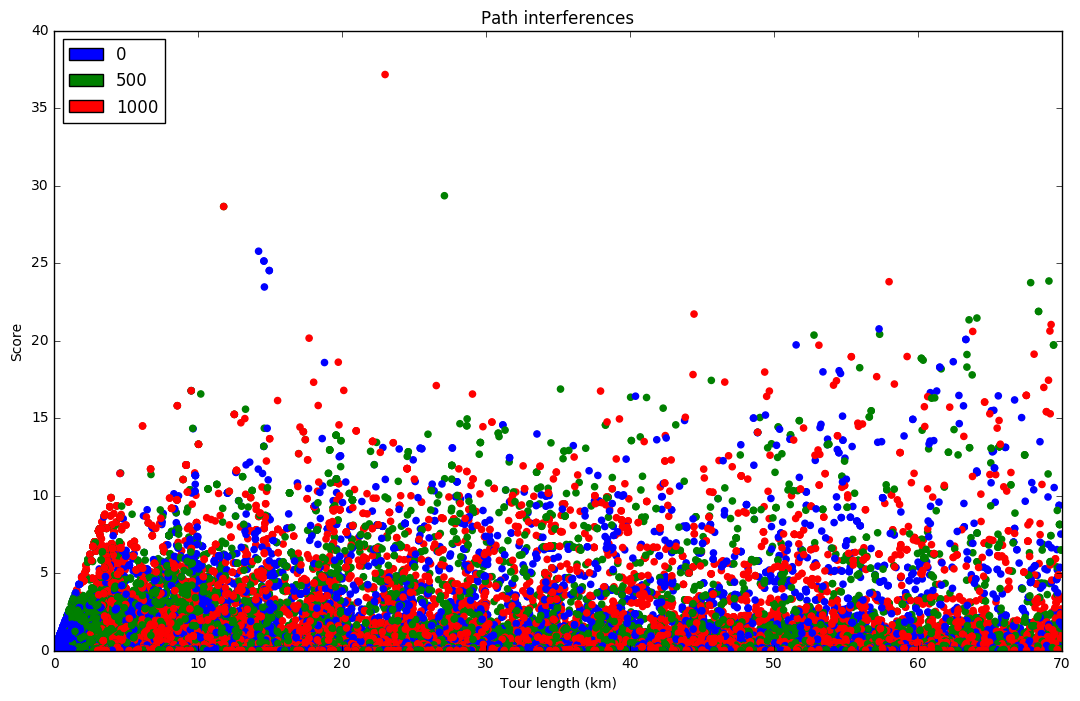

In [12]:
colors = ['b', 'g', 'r']
lens = [float(path['tags']['length'])/1000 for path in paths]
score = [float(path['tags']['score']) for path in paths]
weights = [float(path['tags']['weight']) for path in paths]
interfs = [float(path['tags']['interf']) for path in paths]
types = [colors[int(path['reach']/500)] for path in paths]
plt.figure(figsize=(13, 8))
plt.title('Path scores')
plt.scatter(lens, score, color=types)
plt.xlim([0, 70])
plt.ylim(ymin=0)
plt.ylabel('Score')
plt.xlabel('Tour length (km)')
plt.legend((plt.Circle((0, 0), 1, fc='b'), plt.Circle((0, 0), 1, fc='g'), plt.Circle((0, 0), 1, fc='r')), ('0', '500', '1000'), loc='upper left')
plt.show()
plt.figure(figsize=(13, 8))
plt.title('Path weights')
plt.scatter(lens, weights, color=types)
plt.xlim([0, 70])
plt.ylim(ymin=0)
plt.ylabel('Score')
plt.xlabel('Tour length (km)')
plt.legend((plt.Circle((0, 0), 1, fc='b'), plt.Circle((0, 0), 1, fc='g'), plt.Circle((0, 0), 1, fc='r')), ('0', '500', '1000'))
plt.show()
plt.figure(figsize=(13, 8))
plt.title('Path interferences')
plt.scatter(lens, interfs, color=types)
plt.xlim([0, 70])
plt.ylim(ymin=0)
plt.ylabel('Score')
plt.xlabel('Tour length (km)')
plt.legend((plt.Circle((0, 0), 1, fc='b'), plt.Circle((0, 0), 1, fc='g'), plt.Circle((0, 0), 1, fc='r')), ('0', '500', '1000'), loc='upper left')
plt.show()

In [13]:
outliers = list()
confs = 0
interf_confs = 0
confs = 0
unachieved_confs = 0
unachieved_rates = list()
outliers = list()
for node in data['nodes']:
    d = dict()
    node_confs = 0
    node_unachieved_confs = 0
    for result in node['tag_results']:
        if result['configuration']['reach']==0:
            node_confs += result['configuration']['alternatives']
            node_unachieved_confs += result['configuration']['alternatives'] - len(result['output']['paths'])
            for path in result['output']['paths']:
                if path['tags']['interf']>1:
                    s = str(result['configuration']['minLength'])+'-'+str(result['configuration']['maxLength'])
                    if not s in d:
                        d[s] = 0
                    d[s] += 1
            
    confs += node_confs
    unachieved_confs += node_unachieved_confs
    unachieved_rate = float(node_unachieved_confs)/node_confs
    unachieved_rates.append(unachieved_rate)
    if unachieved_rate>0.1 or len(d):
        outliers.append({'id': node['id'], 'lat': node['lat'], 'lon': node['lon'], 'unachieved_rate': unachieved_rate, 'high_interf': str(d)})
        
with open('path_outliers.json', 'w') as data_file:
    json.dump({'nodes': outliers}, data_file)

print("Unachieved configurations: " + str(100*float(unachieved_confs)/confs) + '%')

Unachieved configurations: 0.9178571428571428%


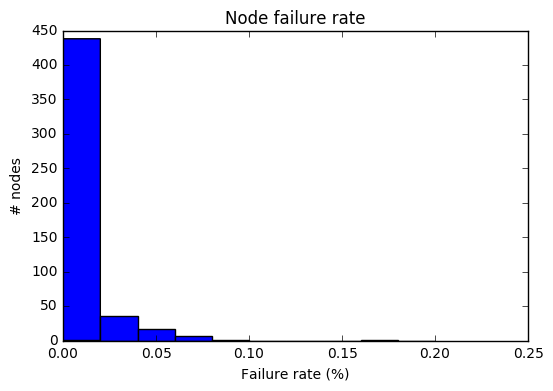

In [14]:
plt.hist(unachieved_rates, range=[0, 0.2])
plt.title('Node failure rate')
plt.xlabel('Failure rate (%)')
plt.ylabel('# nodes')

In [15]:
paths_per_category = [[list() for category in categories] for reach in reaches]
for path in paths:
    paths_per_category[int(path['reach']/500)][int(path['minLength']/5000)].append(float(path['tags']['score']))

for i in range(len(paths_per_category)):
    for j in range(len(paths_per_category[i])):
        paths_per_category[i][j] = np.array(paths_per_category[i][j])

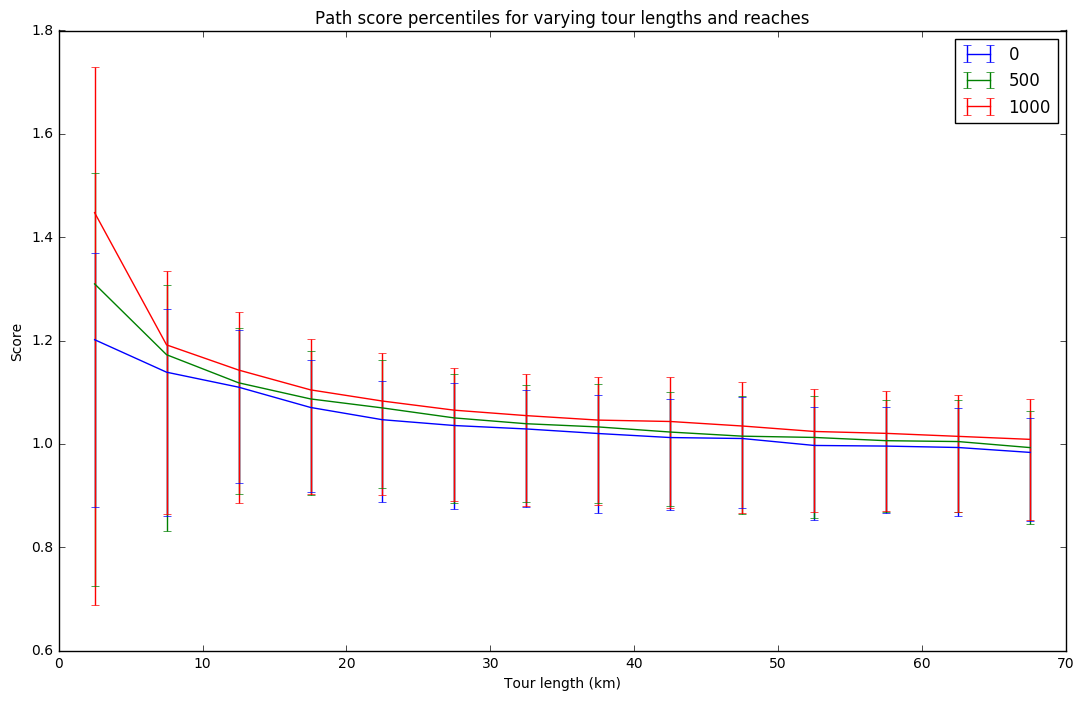

In [16]:
p50_per_category = [np.array([np.percentile(paths_per_category[i][j], 50) for j in range(len(paths_per_category[i]))]) for i in range(len(paths_per_category))]
p75_per_category = [np.array([np.percentile(paths_per_category[i][j], 75) for j in range(len(paths_per_category[i]))]) for i in range(len(paths_per_category))]
p25_per_category = [np.array([np.percentile(paths_per_category[i][j], 25) for j in range(len(paths_per_category[i]))]) for i in range(len(paths_per_category))]

plt.figure(figsize=(13, 8))
plt.errorbar(categories/1000, p50_per_category[0], yerr=[p75_per_category[0]-p50_per_category[0], p50_per_category[0]-p25_per_category[0]], label='0')
plt.errorbar(categories/1000, p50_per_category[1], yerr=[p75_per_category[1]-p50_per_category[1], p50_per_category[1]-p25_per_category[1]], label='500')
plt.errorbar(categories/1000, p50_per_category[2], yerr=[p75_per_category[2]-p50_per_category[2], p50_per_category[2]-p25_per_category[2]], label='1000')
plt.title('Path score percentiles for varying tour lengths and reaches')
plt.ylabel('Score')
plt.xlabel('Tour length (km)')
plt.legend()

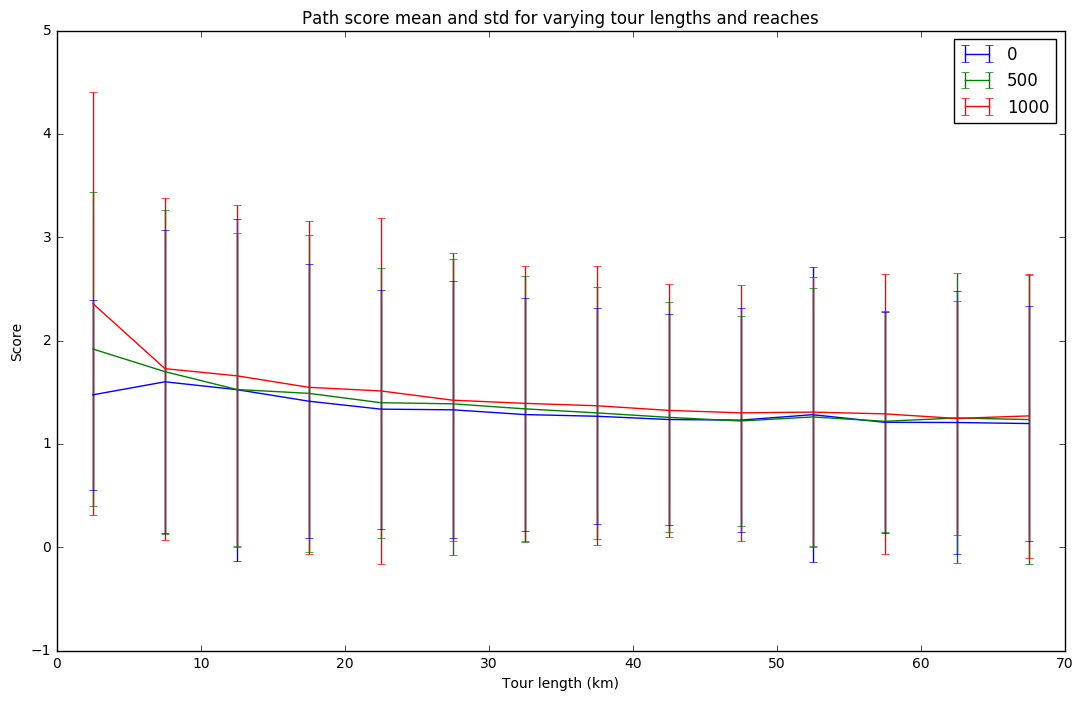

In [17]:
avg_per_category = [[np.mean(paths_per_category[i][j]) for j in range(len(paths_per_category[i]))] for i in range(len(paths_per_category))]
std_per_category = [[np.std(paths_per_category[i][j]) for j in range(len(paths_per_category[i]))] for i in range(len(paths_per_category))]

plt.figure(figsize=(13, 8))
plt.errorbar(categories/1000, avg_per_category[0], yerr=std_per_category[0], label='0')
plt.errorbar(categories/1000, avg_per_category[1], yerr=std_per_category[1], label='500')
plt.errorbar(categories/1000, avg_per_category[2], yerr=std_per_category[2], label='1000')
plt.title('Path score mean and std for varying tour lengths and reaches')
plt.ylabel('Score')
plt.xlabel('Tour length (km)')
plt.legend()

## Execution time

### Outliers

In [61]:
extract = list()
forward = list()
backward = list()
rem = list()
types = list()
lengths = list()

for result in results:
    extract_time = result['output']['extractTime']
    forward_time = result['output']['forwardTime']
    avg_backward_time = result['output']['backwardTimeAvg']
    attempts = result['configuration']['alternatives']
    avg_rem_time = (result['output']['time']-attempts*avg_backward_time-forward_time-extract_time)/attempts
    reach_ind = int(result['configuration']['reach']/500)
    extract.append(extract_time)
    forward.append(forward_time)
    backward.append(avg_backward_time)
    rem.append(avg_rem_time)
    types.append(colors[reach_ind])
    lengths.append((result['configuration']['minLength']+result['configuration']['maxLength'])/2)
    
extract = np.array(extract)
forward = np.array(forward)
backward = np.array(backward)
rem = np.array(rem)
lengths = np.array(lengths)

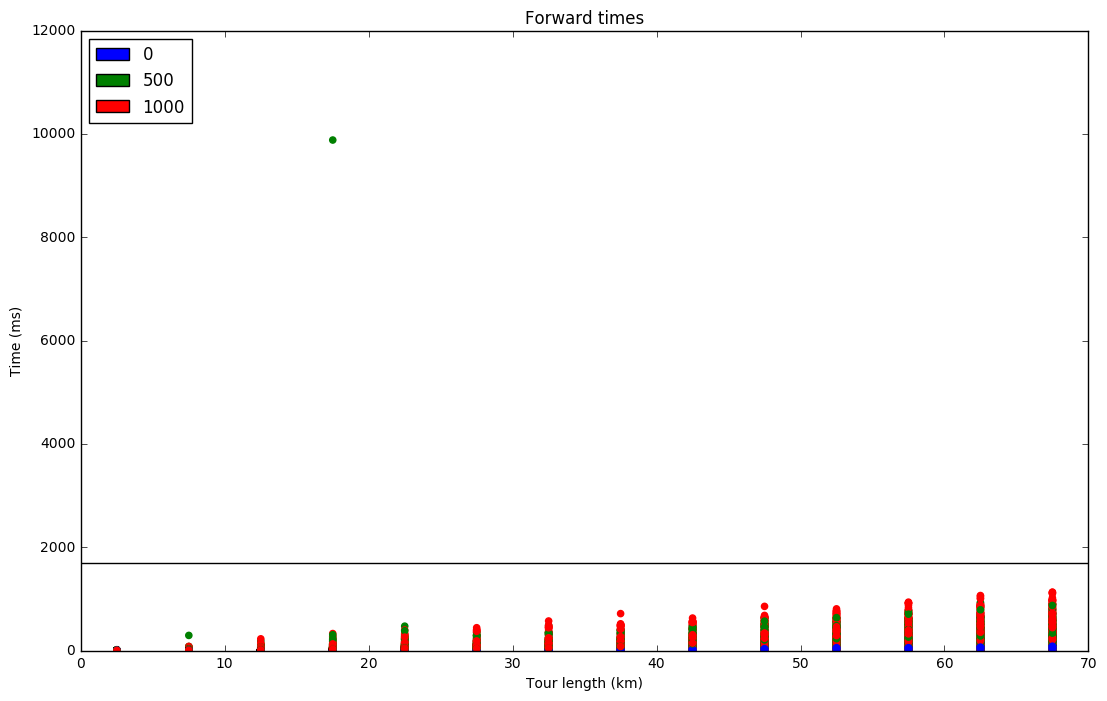

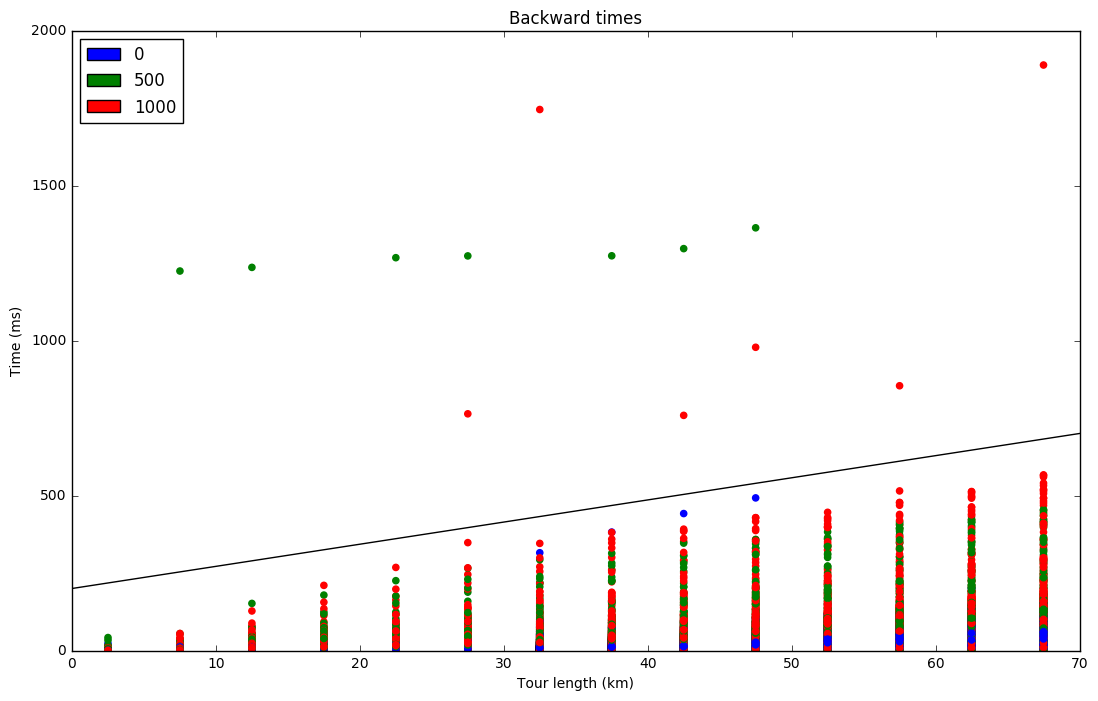

In [64]:
plt.figure(figsize=(13, 8))
plt.title('Forward times')
plt.scatter(lengths/1000, forward*1000, color=types)
plt.xlim([0, 70])
plt.ylim(ymin=0)
plt.ylabel('Time (ms)')
plt.xlabel('Tour length (km)')
plt.plot([0, 70], [1700, 1700], 'k-')
plt.legend((plt.Circle((0, 0), 1, fc='b'), plt.Circle((0, 0), 1, fc='g'), plt.Circle((0, 0), 1, fc='r')), ('0', '500', '1000'), loc='upper left')
plt.show()

plt.figure(figsize=(13, 8))
plt.title('Backward times')
plt.scatter(lengths/1000, backward*1000, color=types)
plt.xlim([0, 70])
plt.ylim(ymin=0)
plt.ylabel('Time (ms)')
plt.xlabel('Tour length (km)')
plt.plot([0, 70], [200, 700], 'k-')
plt.legend((plt.Circle((0, 0), 1, fc='b'), plt.Circle((0, 0), 1, fc='g'), plt.Circle((0, 0), 1, fc='r')), ('0', '500', '1000'), loc='upper left')
plt.show()

In [65]:
nrOutliers = 0
for result in results:
    outlier = False
    reach_ind = int(result['configuration']['reach']/500)
    length = (result['configuration']['minLength']+result['configuration']['maxLength'])/2
    forward_time = result['output']['forwardTime']
    avg_backward_time = result['output']['backwardTimeAvg']
    if (forward_time>1.7):
        outlier = True
    if (avg_backward_time>0.2+length*(0.7-.2)/70000):
        outlier = True
    result['output']['outlierTime'] = outlier
    nrOutliers += outlier

print('Time outliers: ' + str(100*float(nrOutliers)/len(results)) + '%')

Time outliers: 0.06666666666666667%


### Average execution times

In [66]:
extract_per_category = [[list() for category in categories] for reach in reaches]
forward_per_category = [[list() for category in categories] for reach in reaches]
avg_backward_per_category = [[list() for category in categories] for reach in reaches]
avg_rem_per_category = [[list() for category in categories] for reach in reaches]
tot_backward_per_category = [[list() for category in categories] for reach in reaches]
tot_rem_per_category = [[list() for category in categories] for reach in reaches]
extract = list()
forward = list()
backward = list()
rem = list()
types = list()
lengths = list()

for result in results:
    if not result['output']['outlierTime']:
        extract_time = result['output']['extractTime']
        forward_time = result['output']['forwardTime']
        avg_backward_time = result['output']['backwardTimeAvg']
        attempts = result['configuration']['alternatives']
        avg_rem_time = (result['output']['time']-attempts*avg_backward_time-forward_time-extract_time)/attempts
        reach_ind = int(result['configuration']['reach']/500)
        category_ind = int(result['configuration']['minLength']/5000)
        extract_per_category[reach_ind][category_ind].append(extract_time)
        forward_per_category[reach_ind][category_ind].append(forward_time)
        avg_backward_per_category[reach_ind][category_ind].append(avg_backward_time)
        avg_rem_per_category[reach_ind][category_ind].append(avg_rem_time)
        extract.append(extract_time)
        forward.append(forward_time)
        backward.append(avg_backward_time)
        rem.append(avg_rem_time)
        types.append(colors[reach_ind])
        lengths.append((result['configuration']['minLength']+result['configuration']['maxLength'])/2)
        tot_backward_per_category[reach_ind][category_ind].append(avg_backward_time*attempts)
        tot_rem_per_category[reach_ind][category_ind].append(avg_rem_time*attempts)
    
    
for i in range(len(reaches)):
    for j in range(len(categories)):
        extract_per_category[i][j] = np.array(extract_per_category[i][j])
        forward_per_category[i][j] = np.array(forward_per_category[i][j])
        avg_backward_per_category[i][j] = np.array(avg_backward_per_category[i][j])
        avg_rem_per_category[i][j] = np.array(avg_rem_per_category[i][j])
        tot_backward_per_category[i][j] = np.array(tot_backward_per_category[i][j])
        tot_rem_per_category[i][j] = np.array(tot_rem_per_category[i][j])
        
extract = np.array(extract)
forward = np.array(forward)
backward = np.array(backward)
rem = np.array(rem)
lengths = np.array(lengths)

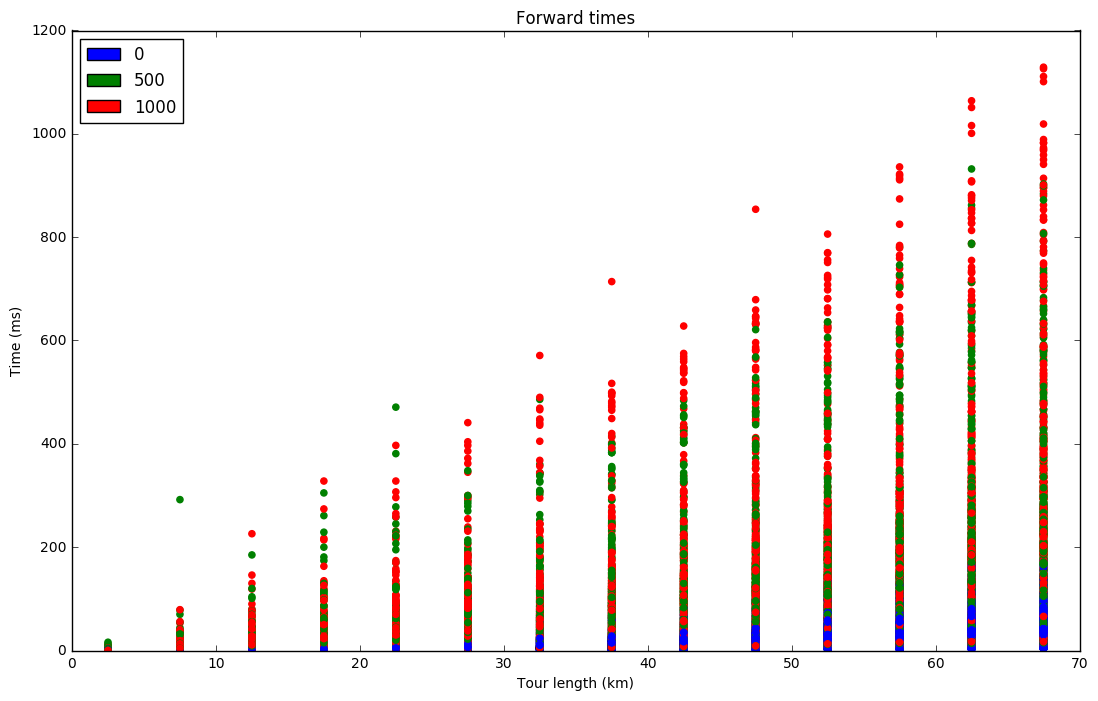

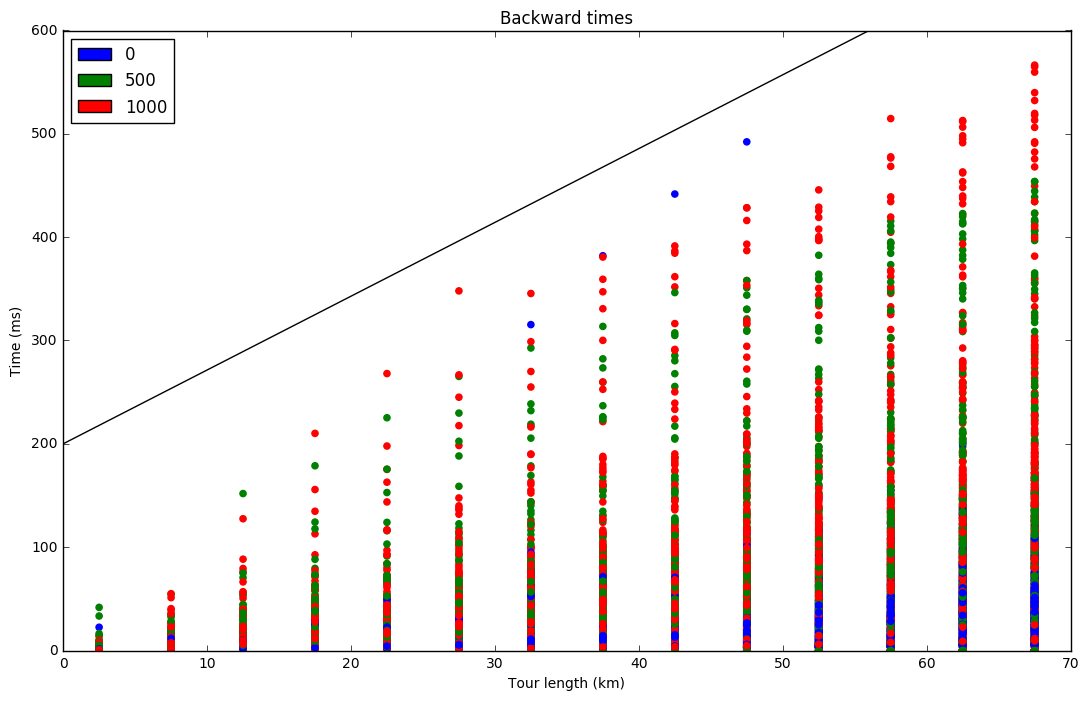

In [69]:
plt.figure(figsize=(13, 8))
plt.title('Forward times')
plt.scatter(lengths/1000, forward*1000, color=types)
plt.xlim([0, 70])
plt.ylim(ymin=0)
plt.ylabel('Time (ms)')
plt.xlabel('Tour length (km)')
plt.plot([0, 70], [1700, 1700], 'k-')
plt.legend((plt.Circle((0, 0), 1, fc='b'), plt.Circle((0, 0), 1, fc='g'), plt.Circle((0, 0), 1, fc='r')), ('0', '500', '1000'), loc='upper left')
plt.show()

plt.figure(figsize=(13, 8))
plt.title('Backward times')
plt.scatter(lengths/1000, backward*1000, color=types)
plt.xlim([0, 70])
plt.ylim(ymin=0)
plt.ylabel('Time (ms)')
plt.xlabel('Tour length (km)')
plt.plot([0, 70], [200, 700], 'k-')
plt.legend((plt.Circle((0, 0), 1, fc='b'), plt.Circle((0, 0), 1, fc='g'), plt.Circle((0, 0), 1, fc='r')), ('0', '500', '1000'), loc='upper left')
plt.show()

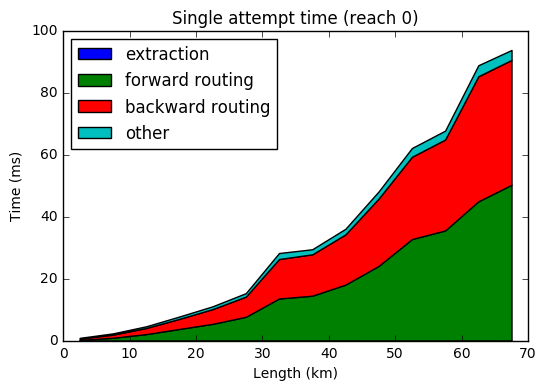

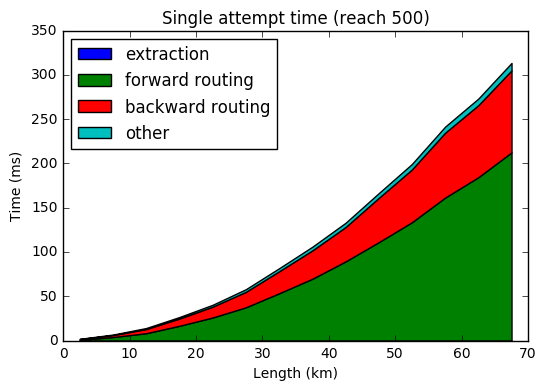

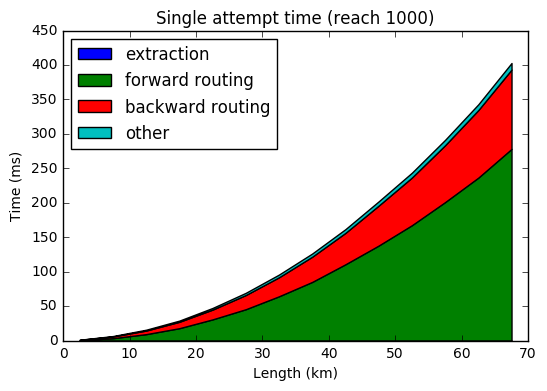

In [70]:
avg_extract_per_category = [[1000*np.mean(extract_per_category[i][j]) for j in range(len(categories))] for i in range(len(reaches))]
avg_forward_per_category = [[1000*np.mean(forward_per_category[i][j]) for j in range(len(categories))] for i in range(len(reaches))]
avg_avg_backward_per_category = [[1000*np.mean(avg_backward_per_category[i][j]) for j in range(len(categories))] for i in range(len(reaches))]
avg_avg_rem_per_category = [[1000*np.mean(avg_rem_per_category[i][j]) for j in range(len(categories))] for i in range(len(reaches))]

plt.figure()
polys = plt.stackplot(categories/1000, avg_extract_per_category[0], avg_forward_per_category[0], avg_avg_backward_per_category[0], avg_avg_rem_per_category[0])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['extraction', 'forward routing', 'backward routing', 'other'], loc='upper left')
plt.title('Single attempt time (reach 0)')
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

plt.figure()
polys = plt.stackplot(categories/1000, avg_extract_per_category[1], avg_forward_per_category[1], avg_avg_backward_per_category[1], avg_avg_rem_per_category[1])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['extraction', 'forward routing', 'backward routing', 'other'], loc='upper left')
plt.title('Single attempt time (reach 500)')
plt.xlim(xmin=0)
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

plt.figure()
polys = plt.stackplot(categories/1000, avg_extract_per_category[2], avg_forward_per_category[2], avg_avg_backward_per_category[2], avg_avg_rem_per_category[2])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['extraction', 'forward routing', 'backward routing', 'other'], loc='upper left')
plt.title('Single attempt time (reach 1000)')
plt.xlim(xmin=0)
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

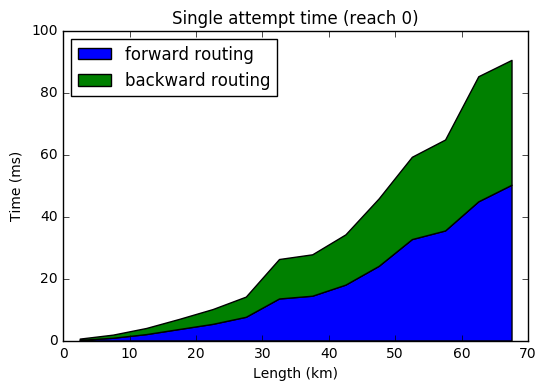

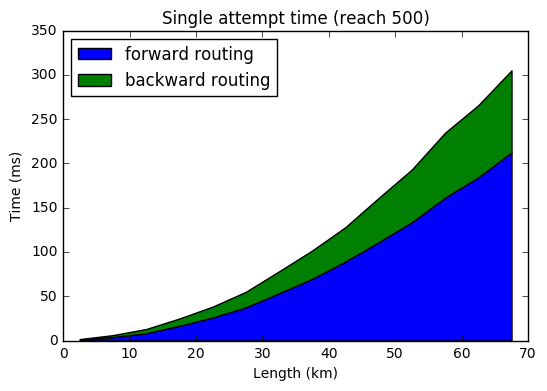

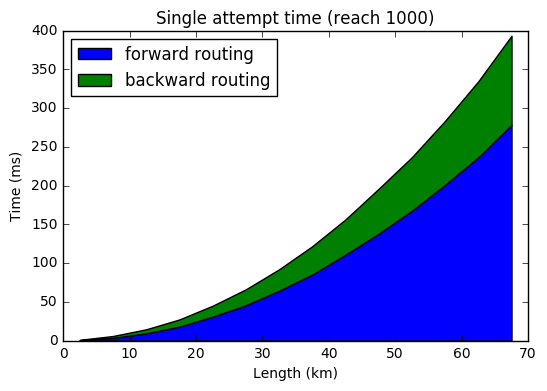

In [71]:
plt.figure()
polys = plt.stackplot(categories/1000, avg_forward_per_category[0], avg_avg_backward_per_category[0])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['forward routing', 'backward routing'], loc='upper left')
plt.title('Single attempt time (reach 0)')
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

plt.figure()
polys = plt.stackplot(categories/1000, avg_forward_per_category[1], avg_avg_backward_per_category[1])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['forward routing', 'backward routing'], loc='upper left')
plt.title('Single attempt time (reach 500)')
plt.xlim(xmin=0)
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

plt.figure()
polys = plt.stackplot(categories/1000, avg_forward_per_category[2], avg_avg_backward_per_category[2])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['forward routing', 'backward routing'], loc='upper left')
plt.title('Single attempt time (reach 1000)')
plt.xlim(xmin=0)
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

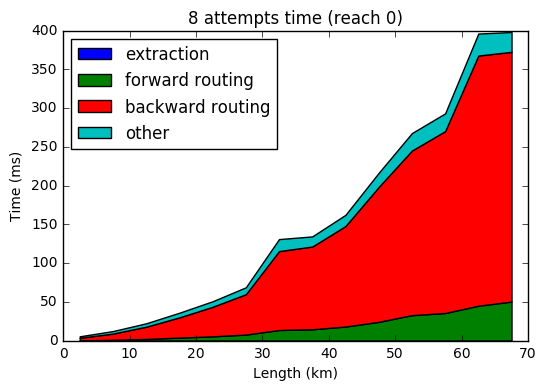

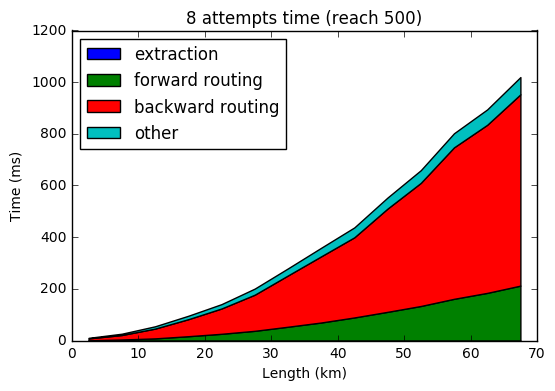

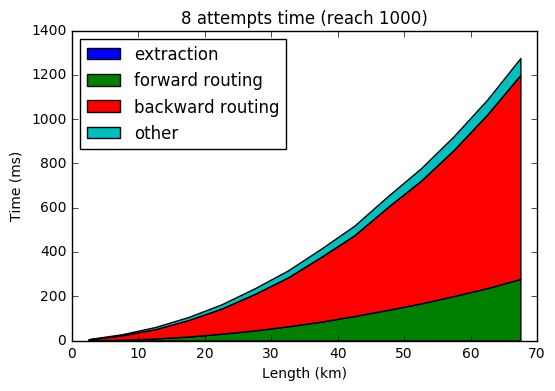

In [72]:
avg_tot_backward_per_category = [[1000*np.mean(tot_backward_per_category[i][j]) for j in range(len(categories))] for i in range(len(reaches))]
avg_tot_rem_per_category = [[1000*np.mean(tot_rem_per_category[i][j]) for j in range(len(categories))] for i in range(len(reaches))]

plt.figure()
polys = plt.stackplot(categories/1000, avg_extract_per_category[0], avg_forward_per_category[0], avg_tot_backward_per_category[0], avg_tot_rem_per_category[0])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['extraction', 'forward routing', 'backward routing', 'other'], loc='upper left')
plt.title('8 attempts time (reach 0)')
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

plt.figure()
polys = plt.stackplot(categories/1000, avg_extract_per_category[1], avg_forward_per_category[1], avg_tot_backward_per_category[1], avg_tot_rem_per_category[1])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['extraction', 'forward routing', 'backward routing', 'other'], loc='upper left')
plt.title('8 attempts time (reach 500)')
plt.xlim(xmin=0)
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

plt.figure()
polys = plt.stackplot(categories/1000, avg_extract_per_category[2], avg_forward_per_category[2], avg_tot_backward_per_category[2], avg_tot_rem_per_category[2])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['extraction', 'forward routing', 'backward routing', 'other'], loc='upper left')
plt.title('8 attempts time (reach 1000)')
plt.xlim(xmin=0)
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

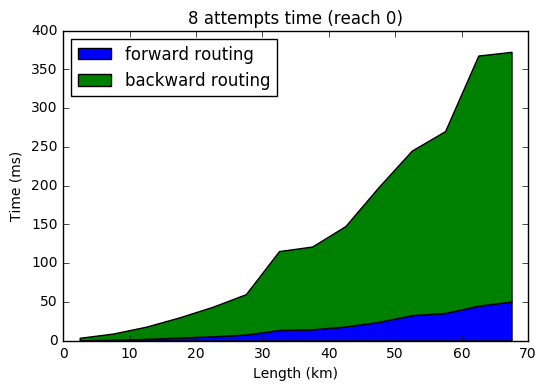

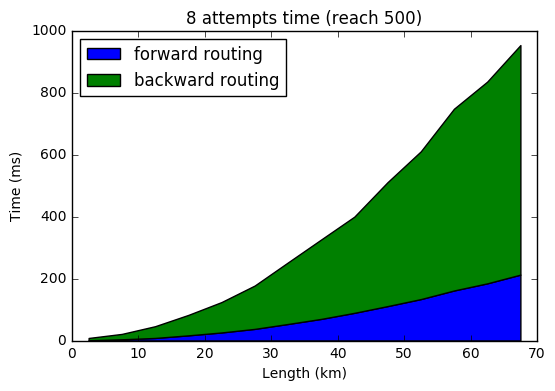

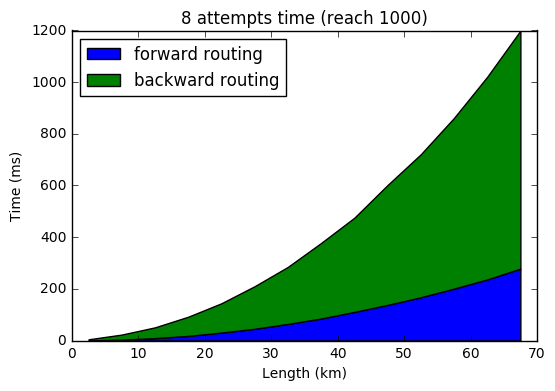

In [73]:
plt.figure()
polys = plt.stackplot(categories/1000, avg_forward_per_category[0], avg_tot_backward_per_category[0])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['forward routing', 'backward routing'], loc='upper left')
plt.title('8 attempts time (reach 0)')
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

plt.figure()
polys = plt.stackplot(categories/1000, avg_forward_per_category[1], avg_tot_backward_per_category[1])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['forward routing', 'backward routing'], loc='upper left')
plt.title('8 attempts time (reach 500)')
plt.xlim(xmin=0)
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()

plt.figure()
polys = plt.stackplot(categories/1000, avg_forward_per_category[2], avg_tot_backward_per_category[2])
legendProxies = []
for poly in polys:
    legendProxies.append(plt.Rectangle((0, 0), 1, 1, fc=poly.get_facecolor()[0]))
plt.legend(legendProxies, ['forward routing', 'backward routing'], loc='upper left')
plt.title('8 attempts time (reach 1000)')
plt.xlim(xmin=0)
plt.xlabel('Length (km)')
plt.ylabel('Time (ms)')
plt.show()